Необходимый объём резервов: 57.42


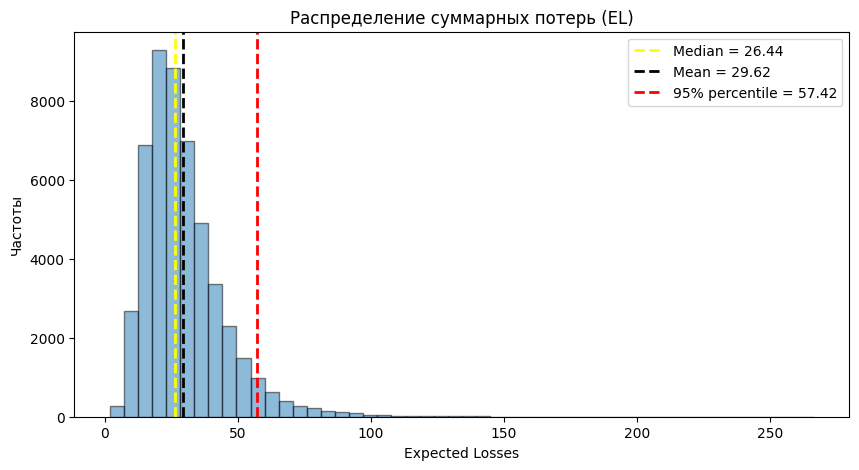

In [50]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Данные из условия
Loans = {
    "A": {"EAD": 1000, "PD_mean": 0.02, "PD_sigma": 0.007, "LGD_min": 0, "LGD_mode": 0.2, "LGD_max": 1},
    "B": {"EAD": 2000, "PD_mean": 0.01, "PD_sigma": 0.005, "LGD_min": 0, "LGD_mode": 0.3, "LGD_max": 1},
    "C": {"EAD": 2500, "PD_mean": 0.015, "PD_sigma": 0.01, "LGD_min": 0, "LGD_mode": 0.4, "LGD_max": 1}
}

# Для рассчёта EL
forEL = {
    "A": {"EAD": 1000, "PD": [], "LGD": [], "EL": []},
    "B": {"EAD": 2000, "PD": [], "LGD": [], "EL": []},
    "C": {"EAD": 2500, "PD": [], "LGD": [], "EL": []}
}

# Количество моделирований
n_samples = 50000

# Моделируем Probability of Default (PD)
for i in Loans:
    sigma2 = np.log(Loans[f"{i}"]["PD_sigma"]**2 / Loans[f"{i}"]["PD_mean"]**2 + 1) # sigma^2 = ln((std / mean)^2 + 1 )
    sigma = sigma2**0.5 # стандартное отклонение для логнормального распределения
    mu = np.log(Loans[f"{i}"]["PD_mean"]) - sigma2 / 2 # математическое ожидание для логнормального распределения mu = ln(mean) - sigma^2 / 2
    Z = np.random.normal(0, 1, n_samples)
    forEL[f"{i}"]["PD"] = np.exp(mu + sigma * Z)

# Моделируем  Loss Given Default (LGD)
for i in Loans:
    alpha = 1 + 4 * (Loans[f"{i}"]["LGD_mode"] - Loans[f"{i}"]["LGD_min"]) / (Loans[f"{i}"]["LGD_max"] - Loans[f"{i}"]["LGD_min"]) # alpha = 1 + 4 * (mode - min) / (max - min)
    beta  = 1 + 4 * (Loans[f"{i}"]["LGD_max"] - Loans[f"{i}"]["LGD_mode"]) / (Loans[f"{i}"]["LGD_max"] - Loans[f"{i}"]["LGD_min"]) # beta  = 1 + 4 * (max - mode) / (max - min)
    betaPERT = np.random.beta(alpha, beta, n_samples)
    forEL[f"{i}"]["LGD"] = Loans[f"{i}"]["LGD_min"] + (Loans[f"{i}"]["LGD_max"] - Loans[f"{i}"]["LGD_min"]) * betaPERT

# Рассчитываем Expected Losses (EL)
for i in Loans:
    forEL[f"{i}"]["EL"] = forEL[f"{i}"]["EAD"] * forEL[f"{i}"]["PD"] * forEL[f"{i}"]["LGD"]

# Рассчитываем суммарный EL
EL_total = [0] * n_samples
for i in forEL:
    EL_total += forEL[f"{i}"]["EL"]

# Вычисляем статистики
EL_total_median = np.median(EL_total)
EL_total_mean = np.mean(EL_total)
EL_total_95 = np.percentile(EL_total, 95)

# Необходимый объём резервов
Reserves = EL_total_95
print(f"Необходимый объём резервов: {Reserves:.2f}")

# Построение гистограммы
plt.figure(figsize=(10, 5))
plt.hist(EL_total, bins=50, edgecolor='black', alpha=0.5)

plt.axvline(EL_total_median, color='yellow', linestyle='--', linewidth=2, label=f"Median = {EL_total_median:.2f}")
plt.axvline(EL_total_mean,   color='black',   linestyle='--', linewidth=2, label=f"Mean = {EL_total_mean:.2f}")
plt.axvline(EL_total_95, color='red',     linestyle='--', linewidth=2, label=f"95% percentile = {EL_total_95:.2f}")

plt.legend()
plt.title("Распределение суммарных потерь (EL)")
plt.xlabel("Expected Losses")
plt.ylabel("Частоты")

plt.show()